This kernel is for detecting lung opacties.
We have three target class's: Normal, No Lung Opacity / Not Normal, Lung Opacity

Dataset contains the following files - Train_images, Test_images, detailed_class_info.csv, train_labels.csv

Overview:- 

1.   Loading the dicom images.
2.   Analyse csv's.
3.   Merge csv's and find relationships between attributes
4.   Look for opportunities to make use of dicom metadata.
5.   Visualize relationships between attributes.
6.   Review dicom images with bounding box's.
7.   Modelling and Prediction.

**Load dataset from Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
#### Define path where the data is present in drive ####
project_path = '/content/drive/My Drive/AI - Great Lakes/Pneumonia/'
zip_path = project_path + 'rsna-pneumonia-detection-challenge.zip'

**All images and csv's are zipped together. We will unzip them as below**

In [4]:
from zipfile import ZipFile

with ZipFile(zip_path, 'r') as z:
  z.extractall()
print("zip extraction done!")

zip extraction done!


**After unzipping - we will try and load some csv to verify if as expected**

In [5]:
import pandas as pd

df = pd.read_csv('stage_2_train_labels.csv')

print(df.iloc[1])

patientId    00313ee0-9eaa-42f4-b0ab-c148ed3241cd
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 1, dtype: object


Above we can see that x, y, width, height and Target are either Null or 0.

This is because there is no lung opacity for this particular patient id.

In [6]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


Above - We can see values for attributes other than PatientId. This is because this particular patientId is found to have lung opacity.

**Images are in Dicom format - so we will require the use of pydicom library**

In [7]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 89kB/s 


**We will load our first dicom image - the metadata alone to verify if we have loaded dicom images correctly**

In [8]:
import pydicom

patientId = df['patientId'][0]
dcm_file = 'stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

Above we can see the various details for a particular patientId which is part of the image.

We can see many attributes, but we will be using only a select few for our study.

Now lets load our csv's to begin our analysis.

In [9]:
class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv')

**Lets check the shape of the two csv's we loaded**

In [10]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


We can see there is equal number of records in both the csv's - 30227

But we need to check if there is any duplicates :) 

In [11]:
uniqueVal_classinfo = class_info_df['patientId'].nunique()
print(uniqueVal_classinfo)

26684


In [12]:
uniqueVal_trainlabels = train_labels_df['patientId'].nunique()
print(uniqueVal_trainlabels)

26684


We can see unique records in both csv's have also turned out to be same but different the total records. 26684.

**Analysis of the CSV's**

In [13]:
class_info_df.sample(5)

patientId                         class
27120  f137ed32-7a53-4b47-b7dc-a75a20701ca3                  Lung Opacity
6430   4edf6d79-0dc8-4b45-b40f-2bdd0665e115                  Lung Opacity
27842  f700d213-ca55-4297-9e4f-4b0cad996a7c  No Lung Opacity / Not Normal
17273  a561b26f-fb7c-452c-b651-9588d51770ad                        Normal
8472   5fa666d0-e617-46a3-b46b-1e7dfe13cac9                        Normal

We can see two attributes for class_info_df : patientId and Class

Class is our target variable.

In [14]:
train_labels_df.sample(5)


patientId   x   y  width  height  Target
29426  153fce06-c27b-4eda-8db1-9f1c60ccf4a2 NaN NaN    NaN     NaN       0
20963  be789252-fbee-4153-9373-ae7d1fc37f3f NaN NaN    NaN     NaN       0
12888  82753032-9df6-40ba-b108-03cb03e3bff1 NaN NaN    NaN     NaN       0
23057  cfd5b32e-0b3f-4cb5-b502-ee042473aa7e NaN NaN    NaN     NaN       0
24405  db567cb4-b9c9-4ff9-b8b0-8c33ce7dd4ec NaN NaN    NaN     NaN       0

Data in train_labels_df is mapped to the training images we have.

We can see nulls and values, indicating no lung opacity and lung opacties for few patientID respectively.


we will be merging the two csv's based patientId for further analysis.

In [15]:
train_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId')

In [16]:
print(f"Combined csv's -  rows: {train_df.shape[0]}, columns: {train_df.shape[1]}")

Combined csv's -  rows: 37629, columns: 7


New shape after combining is 37629 records.

In [17]:
train_df.sample(3)

patientId     x  ...  Target         class
4105   3502cf28-bcc2-4cf4-84bc-749ccc2dd222  94.0  ...       1  Lung Opacity
933    097df78d-7101-478a-9e33-2748a084e01e   NaN  ...       0        Normal
28326  c9c976bf-b105-4b7d-ba23-e2922186c95f   NaN  ...       0        Normal

[3 rows x 7 columns]

In [18]:
#train_class_df.patientId.unique()

uniqueValues = train_df['patientId'].nunique()
print(uniqueValues)


26684


We can see duplicate records after merging as well. Nothing to worry aboout.

This indicates a particular patientId may have more than one bounding box's.

In [19]:
train_df.describe(include='all')

patientId  ...         class
count                                  37629  ...         37629
unique                                 26684  ...             3
top     7d674c82-5501-4730-92c5-d241fd6911e7  ...  Lung Opacity
freq                                      16  ...         16957
mean                                     NaN  ...           NaN
std                                      NaN  ...           NaN
min                                      NaN  ...           NaN
25%                                      NaN  ...           NaN
50%                                      NaN  ...           NaN
75%                                      NaN  ...           NaN
max                                      NaN  ...           NaN

[11 rows x 7 columns]

Class has three unique values as mentioned earlier. Also we can see the unique records and total records has similar results from before.

**We begin visualing the merged dataframe**

Checking the spread of our target attribute in the dataset with percentages.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


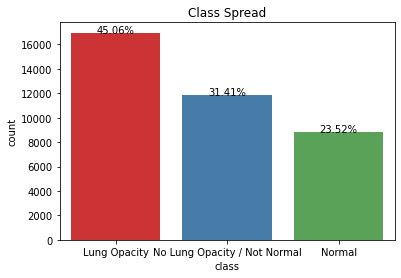

In [20]:
# import neccessary librarires for visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns


f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(train_df))

#using count plot
sns.countplot(train_df['class'],order = train_df['class'].value_counts().index, palette='Set1')

#Calculating percentages from total
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 

plt.title("Class Spread")
plt.show()

Lung Opacity is the majority class in our dataset- 45.06% and least is Normal - 23.52%

The spread of our is good enough else would bias our results.

Visualize - classifications of three class's w.r.t target

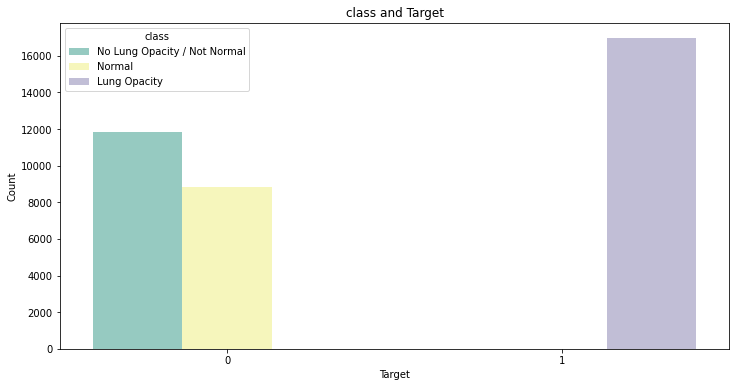

In [21]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_df.groupby('Target')['class'].value_counts()

# We are creating a new column count for analysis
df = pd.DataFrame(data={'Count': tmp.values}, index=tmp.index).reset_index()

sns.barplot(ax=ax,x = 'Target', y='Count',hue='class',data=df, palette='Set3')

plt.title("class and Target")
plt.show()

We see target 0 is majority and it invloves to of the three class - No Lung Opacity/Not Normal and Normal.

We can consider 'No Lung Opacity/Not Normal' to be normal but in reality it might point to a different set of diseases, here we are analysing Pneumonia :)

**Lets analyze the metadata from dicom images of our training set.**

In [22]:
import glob

#Custom function to read through the metadata of dicom
def formatMetadataString(val):
    return str(val).split(':')[1].replace('\'', '')

#path of our unzipped data
dataDir = '/content'

trainDataDir = 'stage_2_train_images'
#testDataDir = 'stage_2_test_images'

# Read the dicom images using glob
trainfiles = glob.glob(os.path.join(dataDir, trainDataDir, "*.dcm"))

print('**Reading the metadata from dicom training files**')

# we are going to read a select few attributes from the metadata of dicom images and the rest we deem to be unecessary for now

image_data = []
for f in trainfiles:    
    ds = pydicom.dcmread(f, stop_before_pixels=True)

    patientId = formatMetadataString(ds['PatientID'])
    age = formatMetadataString(ds['PatientAge'])
    gender = formatMetadataString(ds['PatientSex'])
    viewPos = formatMetadataString(ds['ViewPosition'])
    modality = formatMetadataString(ds['Modality'])
    pixelspacing = formatMetadataString(ds['PixelSpacing'])
    
    image_data.append([patientId, int(age), gender, viewPos, modality, pixelspacing])
 
 #create new dataframe from the select attributes of the dicom images
image_metadata_df = pd.DataFrame(image_data, columns=['patientId', 'Age', 'Gender','ViewPosition', 'Modality', 'PixelSpacing'])        
image_metadata_df.head(3)

**Reading the metadata from dicom training files**


patientId  ...                                 PixelSpacing
0   5d886b14-0764-49b8-a6f6-23033107ec5b  ...                               [0.139, 0.139]
1   5edecee7-9bcb-43b3-9bcf-3f35265d6a6e  ...   [0.14300000000000002, 0.14300000000000002]
2   3ec704b7-82b3-4a0b-a5c8-cbce731fcb51  ...                               [0.139, 0.139]

[3 rows x 6 columns]

'patientId', 'Age', 'Gender','ViewPosition', 'Modality', 'PixelSpacing' are few of the attributes we decided to analyse.

In [23]:
unique_metadata = image_metadata_df.patientId.nunique()
print(unique_metadata)

26684


unique metadata count - 26684. similar to our csv's

**Further analysis of our new dataframe - understanding the dataset**

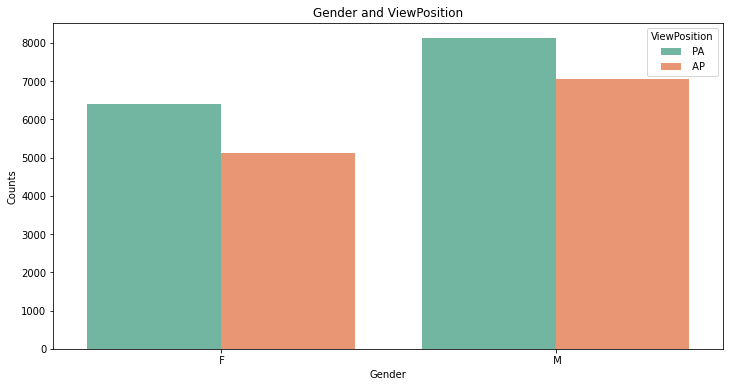

In [24]:
#plotting
fig, ax = plt.subplots(nrows=1,figsize=(12,6))

tmp = image_metadata_df.groupby('Gender')['ViewPosition'].value_counts()

#new attribute creation to analyse
df = pd.DataFrame(data={'Counts': tmp.values}, index=tmp.index).reset_index()

sns.barplot(ax=ax,x = 'Gender', y='Counts',hue='ViewPosition',data=df, palette='Set2')

plt.title("Gender and ViewPosition")
plt.show()

Data spread of ViewPosition w.r.t Gender is even. We can see there is basically only two types of ViewPosition in our dataset - PA and AP

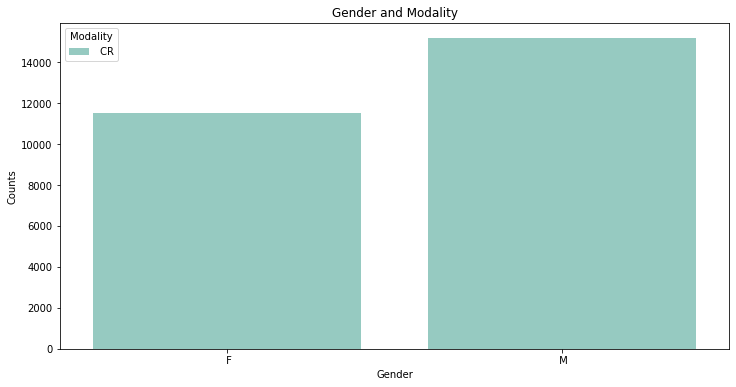

In [25]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))

tmp = image_metadata_df.groupby('Gender')['Modality'].value_counts()

#creating new attribute to analyze
df = pd.DataFrame(data={'Counts': tmp.values}, index=tmp.index).reset_index()

sns.barplot(ax=ax,x = 'Gender', y='Counts',hue='Modality',data=df, palette='Set3')

plt.title("Gender and Modality")
plt.show()

Gender vs Modailty is spread even as well. Modality contains only single unique value - CR

We will be merging the metadata df with earlier combined df as a single source for reference.

In [26]:
train_df1 = train_df.reset_index().drop('index', axis=1)

patient_df = image_metadata_df.join(train_df1, how='outer', rsuffix='_2')

patient_df.drop('patientId_2', axis=1, inplace=True)

patient_df.head()

patientId  ...                         class
0   5d886b14-0764-49b8-a6f6-23033107ec5b  ...  No Lung Opacity / Not Normal
1   5edecee7-9bcb-43b3-9bcf-3f35265d6a6e  ...  No Lung Opacity / Not Normal
2   3ec704b7-82b3-4a0b-a5c8-cbce731fcb51  ...  No Lung Opacity / Not Normal
3   416b2485-3152-47b8-9aba-2d33822f1200  ...                        Normal
4   6961f4d4-addd-45a7-9053-2e8959fa4562  ...                  Lung Opacity

[5 rows x 12 columns]

We can now see the combined dataset and further analyse.

In [27]:
counts=patient_df.patientId.nunique()
counts

26684

Still unique records to be 26684

In [28]:
# shape of the final combined df

print(f"Combined csv's -  rows: {patient_df.shape[0]}, columns: {patient_df.shape[1]}")

Combined csv's -  rows: 37629, columns: 12


Visualize gender wrt class

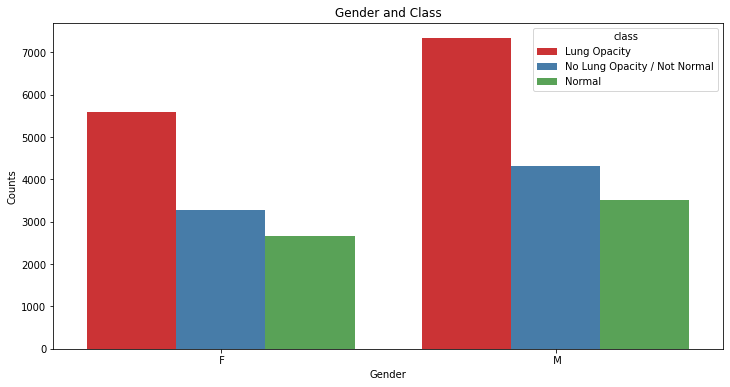

In [29]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))

tmp = patient_df.groupby('Gender')['class'].value_counts()
#new attribute creation
df = pd.DataFrame(data={'Counts': tmp.values}, index=tmp.index).reset_index()

sns.barplot(ax=ax,x = 'Gender', y='Counts',hue='class',data=df, palette='Set1')
plt.title("Gender and Class")
plt.show()

Even distribution among class's for a gender is seen.

Also male gender is seen to have most lung opacity.

Visualize - ViewPosition and Class

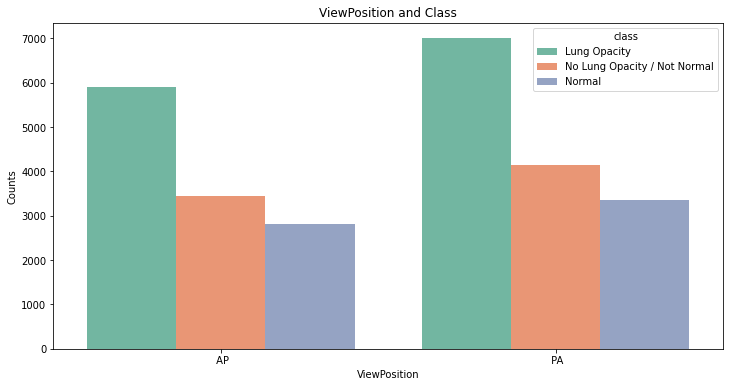

In [30]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))

tmp = patient_df.groupby('ViewPosition')['class'].value_counts()

df = pd.DataFrame(data={'Counts': tmp.values}, index=tmp.index).reset_index()

sns.barplot(ax=ax,x = 'ViewPosition', y='Counts',hue='class',data=df, palette='Set2')
plt.title("ViewPosition and Class")
plt.show()

Even spread noticed here as well. All this indicates to a good dataset.

Visualize counts - Age and class

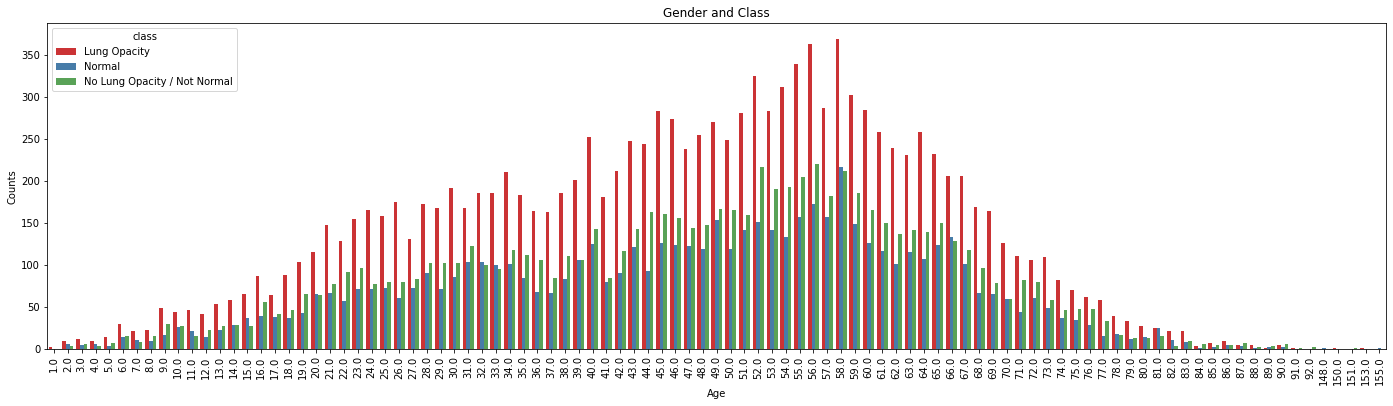

In [31]:
fig, ax = plt.subplots(nrows=1,figsize=(24,6))

tmp = patient_df.groupby('Age')['class'].value_counts()

df = pd.DataFrame(data={'Counts': tmp.values}, index=tmp.index).reset_index()

sns.barplot(ax=ax,x = 'Age', y='Counts',hue='class',data=df, palette='Set1')
plt.title("Gender and Class")
plt.xticks(rotation=90)
plt.show()

We can see 50 to 60 range ages having most lung opacity issues.

Also we can see extreme data points here - 140+ and 3- 
We can ignore or create a bracket for the same

**Lets now view our first image**

We will need custom functions to process the dicom images.

In [32]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()
    
# we are going to display metadata along with the image
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)

#image dimensions    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

In [33]:
# method to plot the image
def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

We will be viewing mutliple images at a time. Images and its corresponding metadata is shown.

Filename.........: /content/stage_2_train_images/5d886b14-0764-49b8-a6f6-23033107ec5b.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 5d886b14-0764-49b8-a6f6-23033107ec5b, 
Patient id..........: 5d886b14-0764-49b8-a6f6-23033107ec5b
Patient's Age.......: 21
Patient's Sex.......: F
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 145528 bytes
Pixel spacing....: [0.139, 0.139]


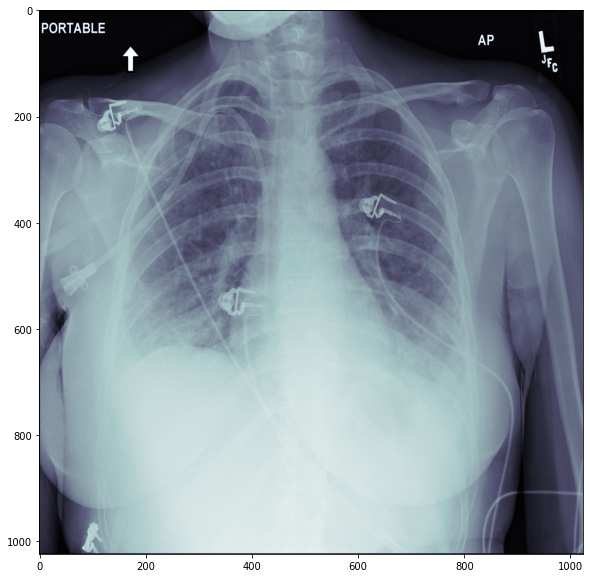

Filename.........: /content/stage_2_train_images/5edecee7-9bcb-43b3-9bcf-3f35265d6a6e.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 5edecee7-9bcb-43b3-9bcf-3f35265d6a6e, 
Patient id..........: 5edecee7-9bcb-43b3-9bcf-3f35265d6a6e
Patient's Age.......: 44
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 151308 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]


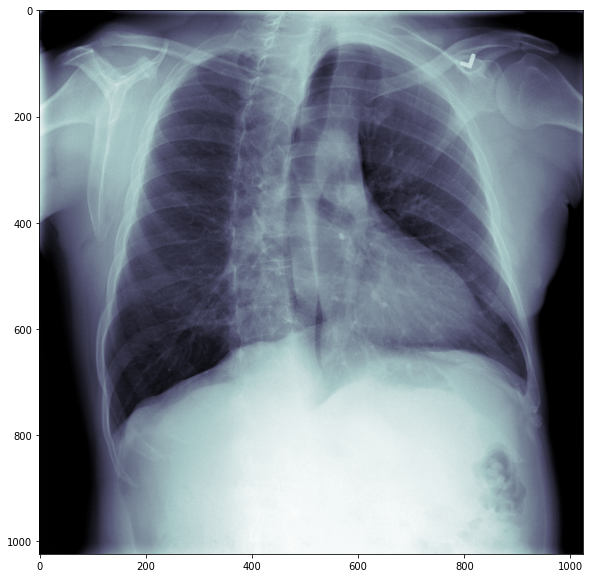

Filename.........: /content/stage_2_train_images/3ec704b7-82b3-4a0b-a5c8-cbce731fcb51.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 3ec704b7-82b3-4a0b-a5c8-cbce731fcb51, 
Patient id..........: 3ec704b7-82b3-4a0b-a5c8-cbce731fcb51
Patient's Age.......: 26
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 120638 bytes
Pixel spacing....: [0.139, 0.139]


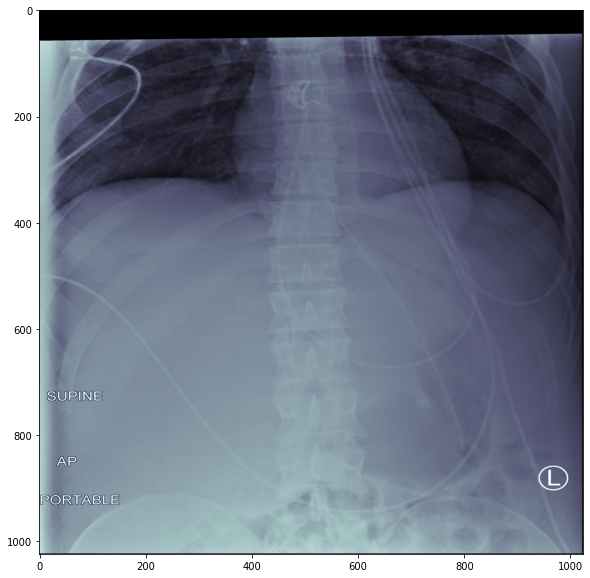

Filename.........: /content/stage_2_train_images/416b2485-3152-47b8-9aba-2d33822f1200.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 416b2485-3152-47b8-9aba-2d33822f1200, 
Patient id..........: 416b2485-3152-47b8-9aba-2d33822f1200
Patient's Age.......: 40
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 151810 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]


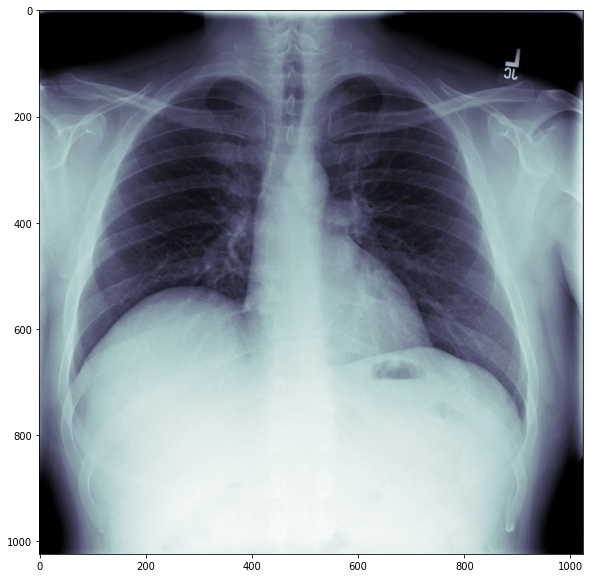

Filename.........: /content/stage_2_train_images/6961f4d4-addd-45a7-9053-2e8959fa4562.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 6961f4d4-addd-45a7-9053-2e8959fa4562, 
Patient id..........: 6961f4d4-addd-45a7-9053-2e8959fa4562
Patient's Age.......: 65
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 120200 bytes
Pixel spacing....: [0.171, 0.171]


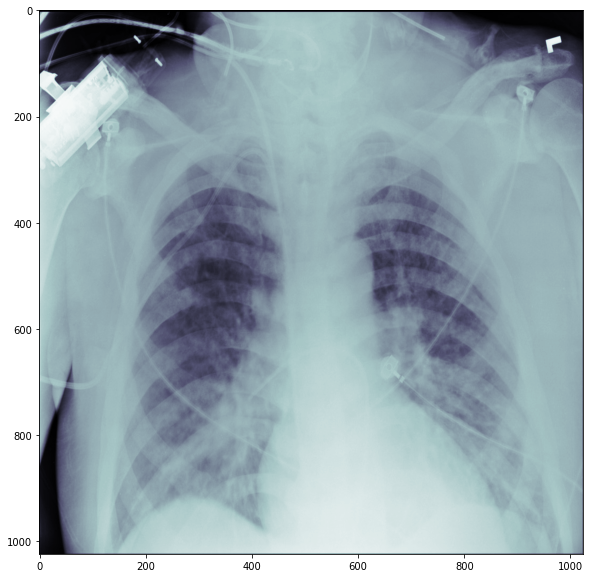

In [34]:
#Display images

i = 1
to_plot = 5
for file_name in os.listdir('/content/stage_2_train_images/'):
    file_path = os.path.join('/content/stage_2_train_images/', file_name)
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    
    if i >= to_plot:
        break
    
    i += 1

We just viewed the images in its raw size and we have looped through 5 dicom patientid's.

We can also view the metadata for each image.

**Sample - Image with bounding box**

In [35]:
# Forked from `https://www.kaggle.com/peterchang77/exploratory-data-analysis`
import numpy as np

def parse_data(df):
    
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(train_labels_df)

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [255, 251, 204] # Just use yellow
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=15)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=2):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

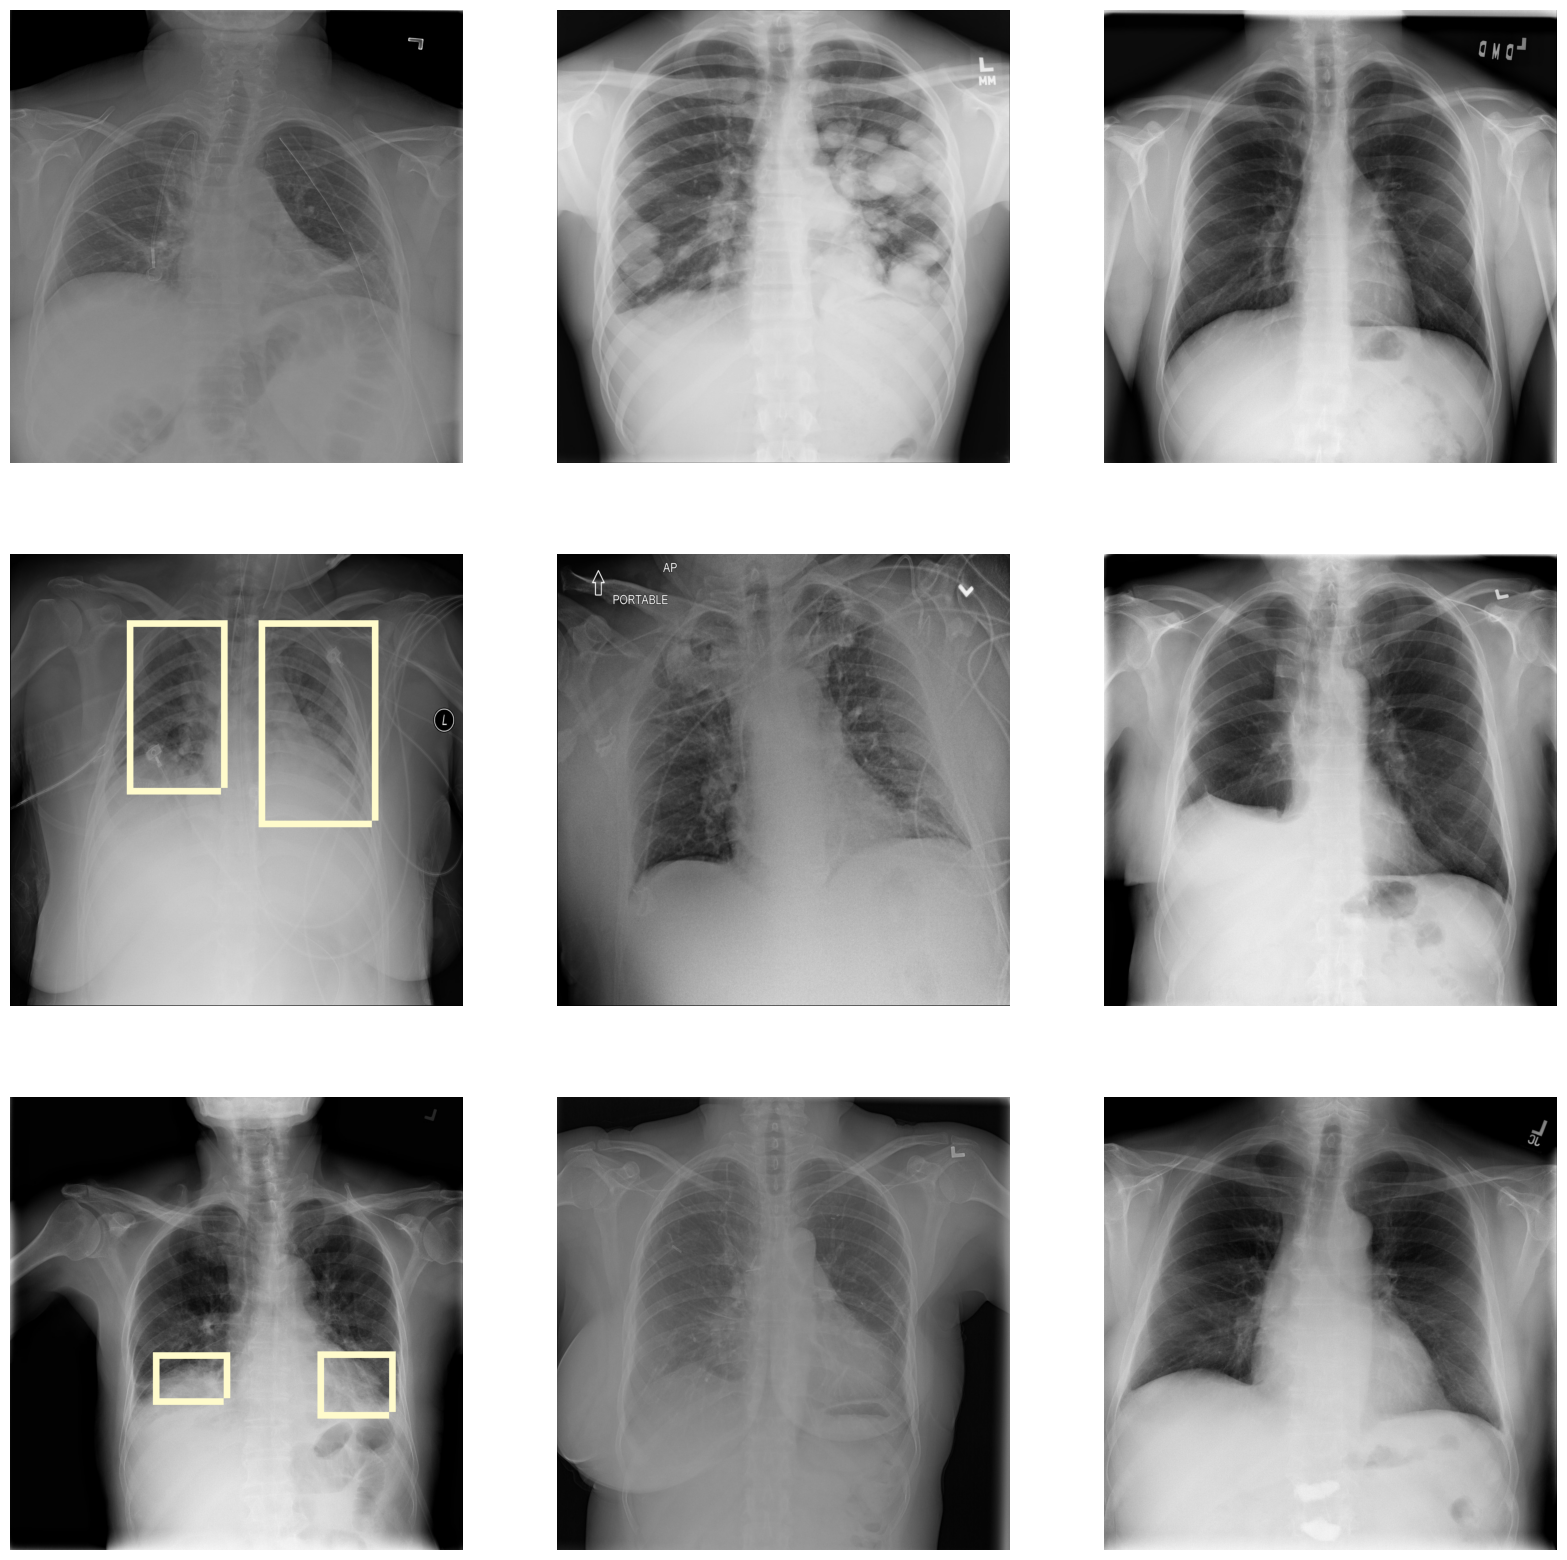

In [36]:
import matplotlib.pylab as plt

plt.style.use('default')
fig=plt.figure(figsize=(20, 20))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[train_labels_df['patientId'].unique()[i]])
    fig.add_subplot

we can see images which are having bounding box's(patient with lung opacity) now.

In [37]:
opacity = class_info_df \
    .loc[class_info_df['class'] == 'Lung Opacity'] \
    .reset_index()
not_normal = class_info_df \
    .loc[class_info_df['class'] == 'No Lung Opacity / Not Normal'] \
    .reset_index()
normal = class_info_df \
    .loc[class_info_df['class'] == 'Normal'] \
    .reset_index()

**Only Lung_Opacity Image**

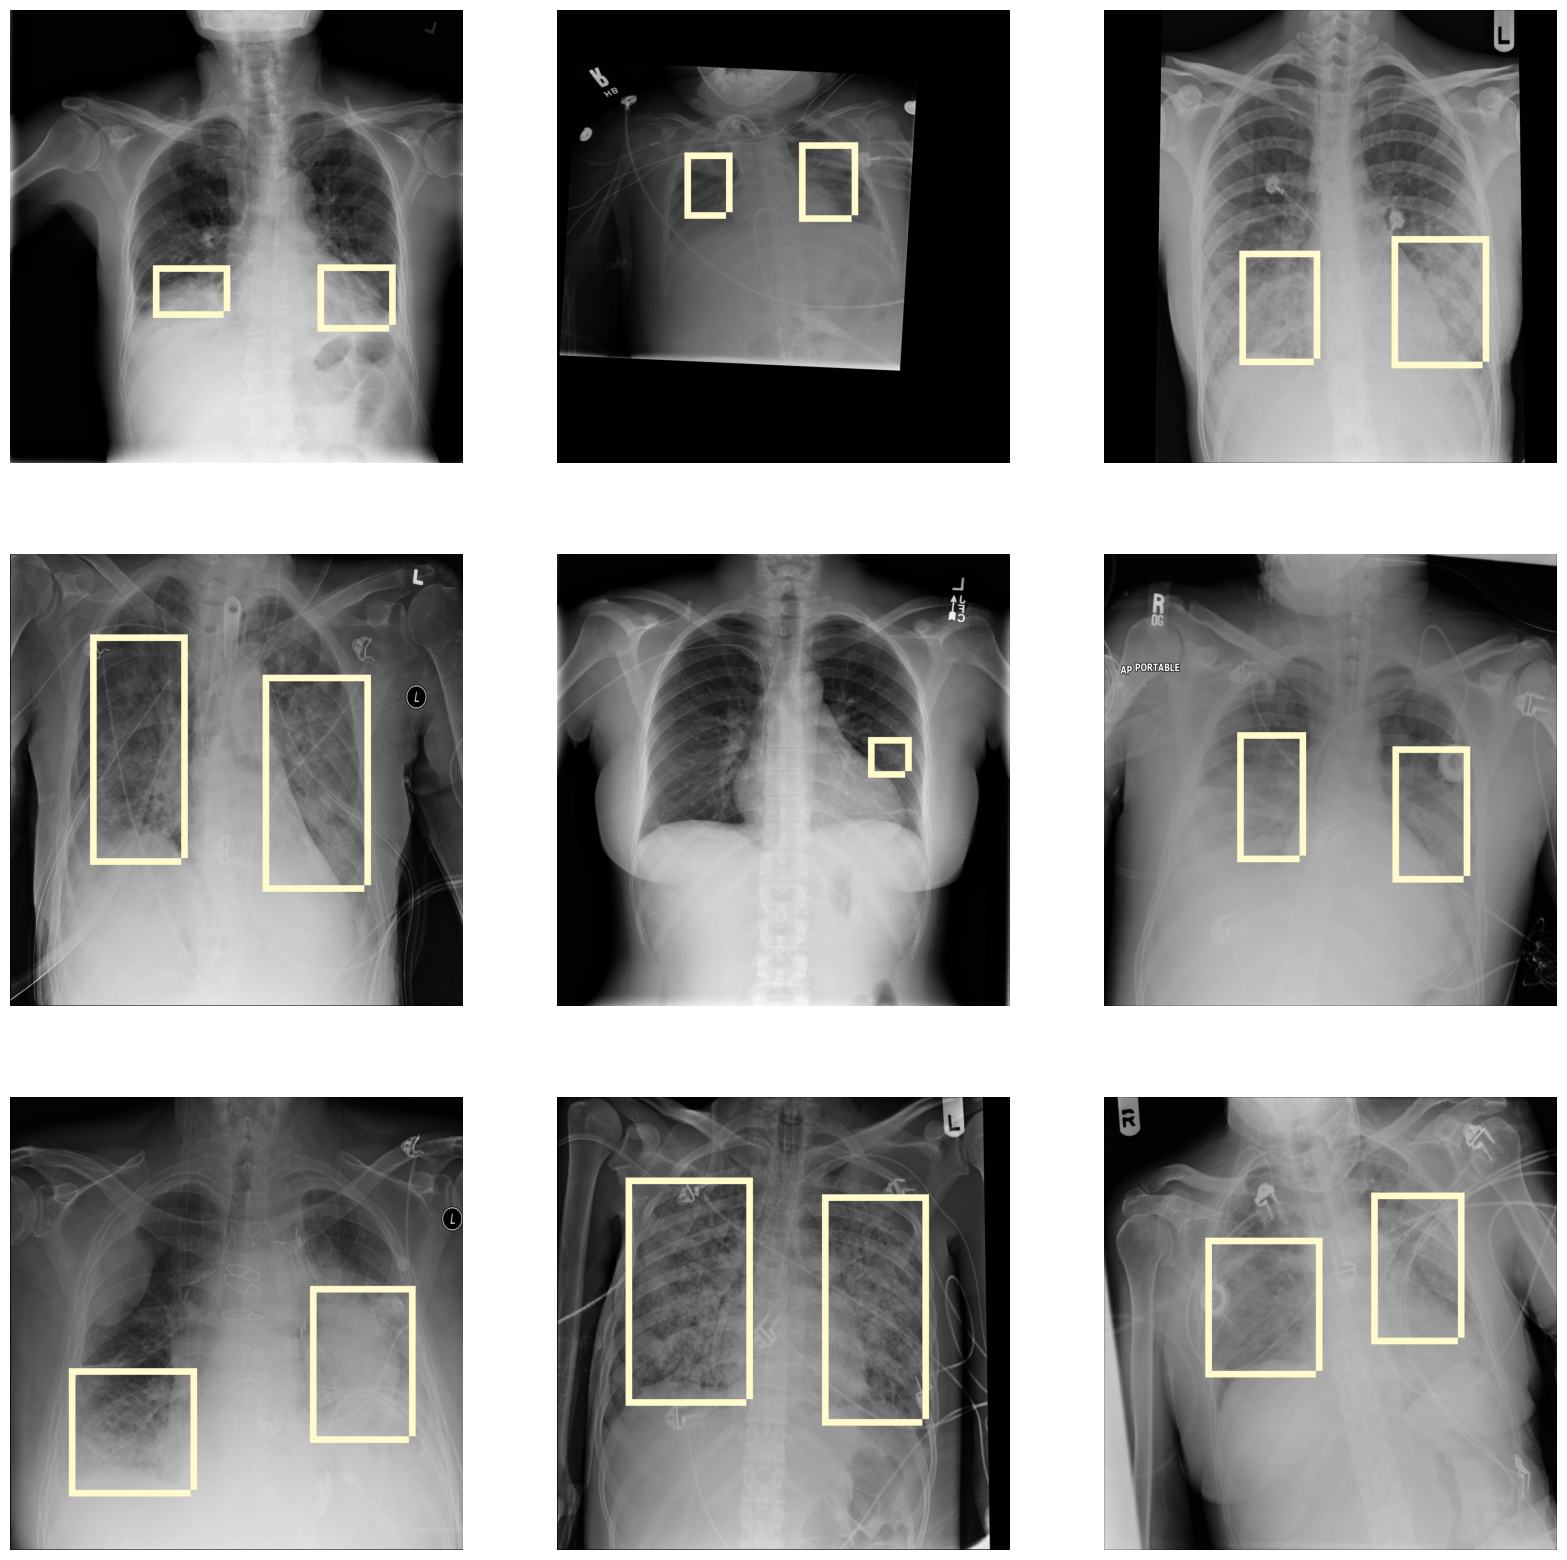

In [38]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 20))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[opacity['patientId'].unique()[i]])

**Only Not_Normal_Opacity Image**

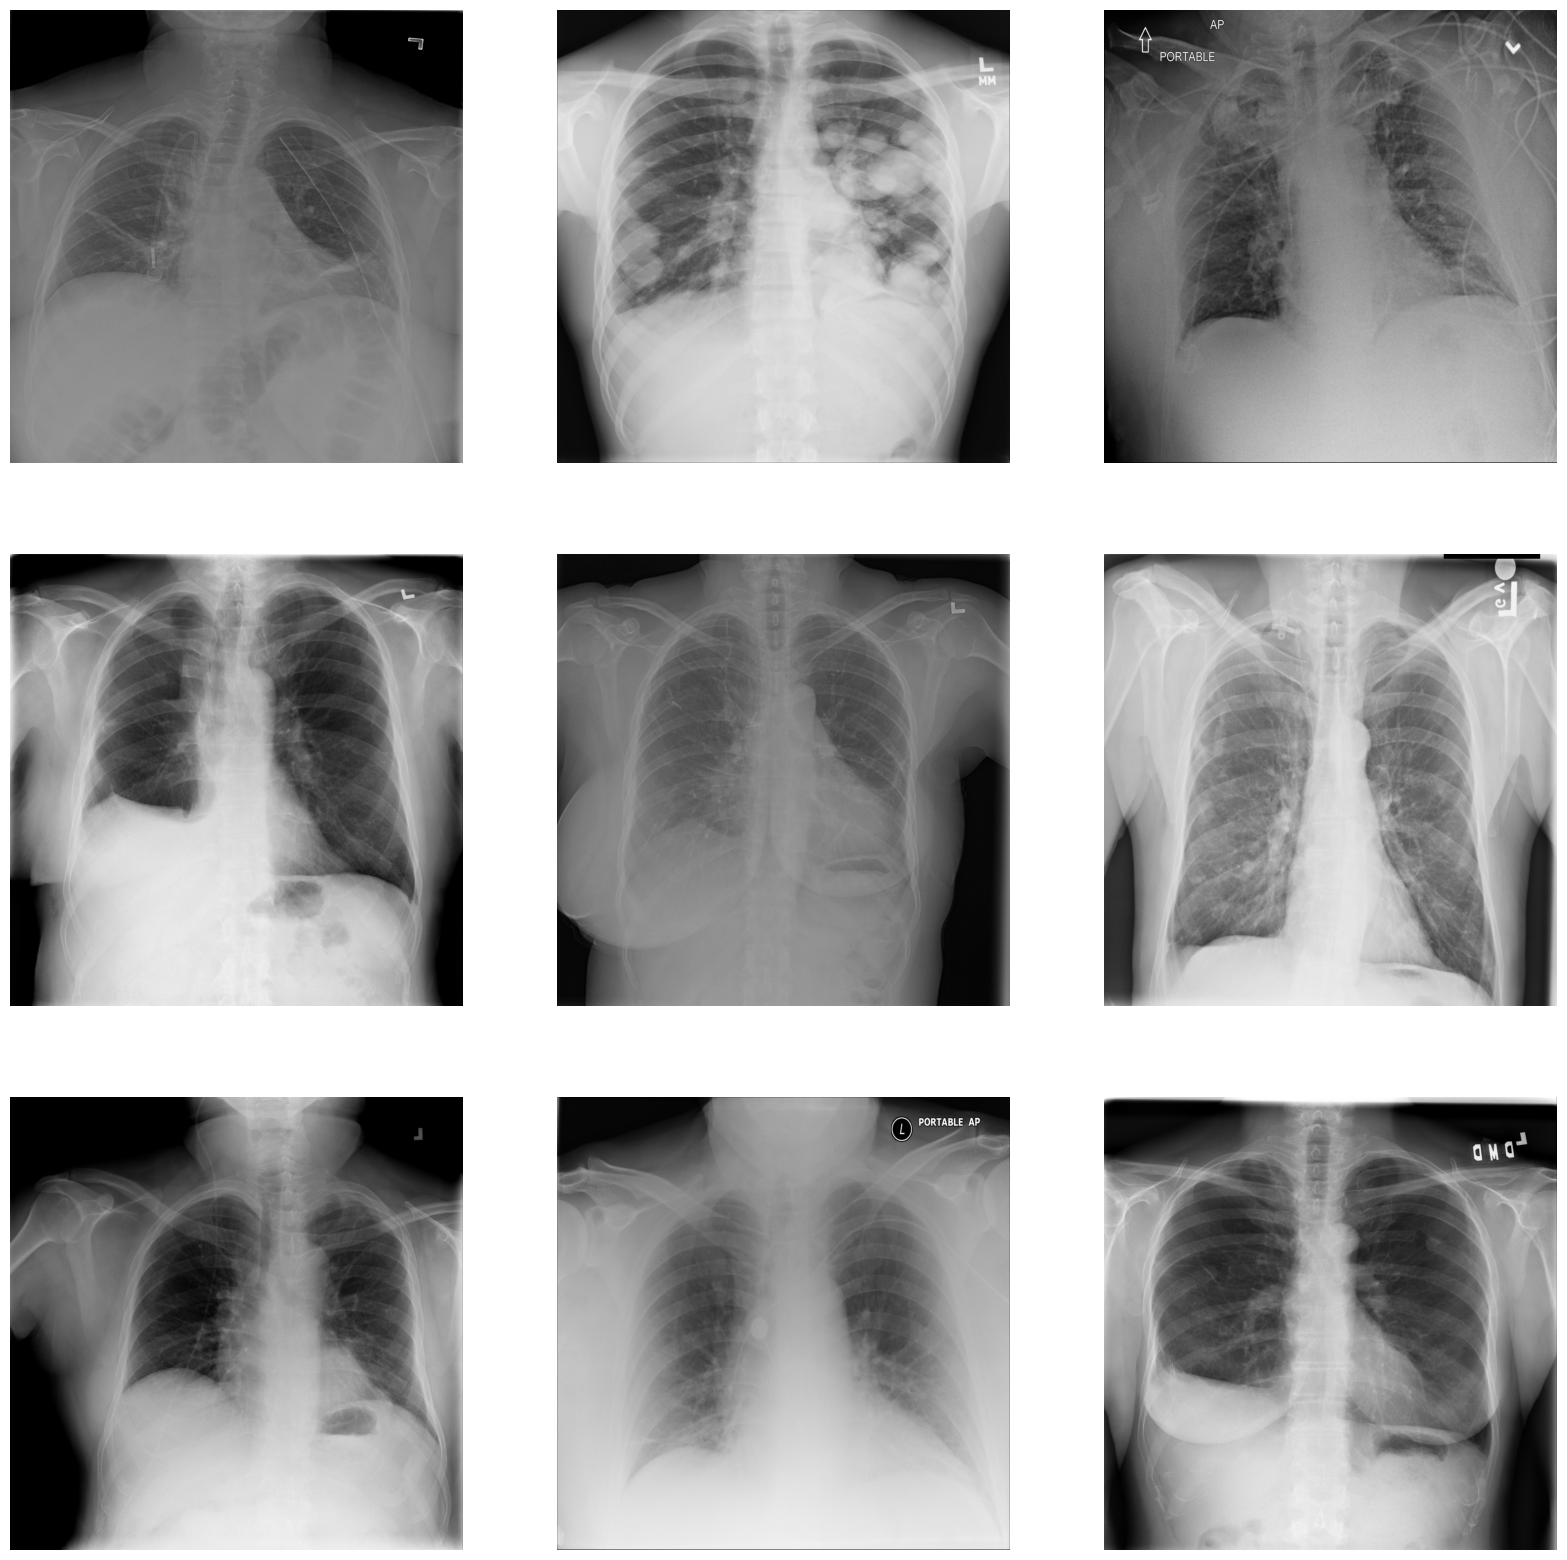

In [39]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 20))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[not_normal['patientId'].loc[i]])

**Only Normal_Opacity Image**

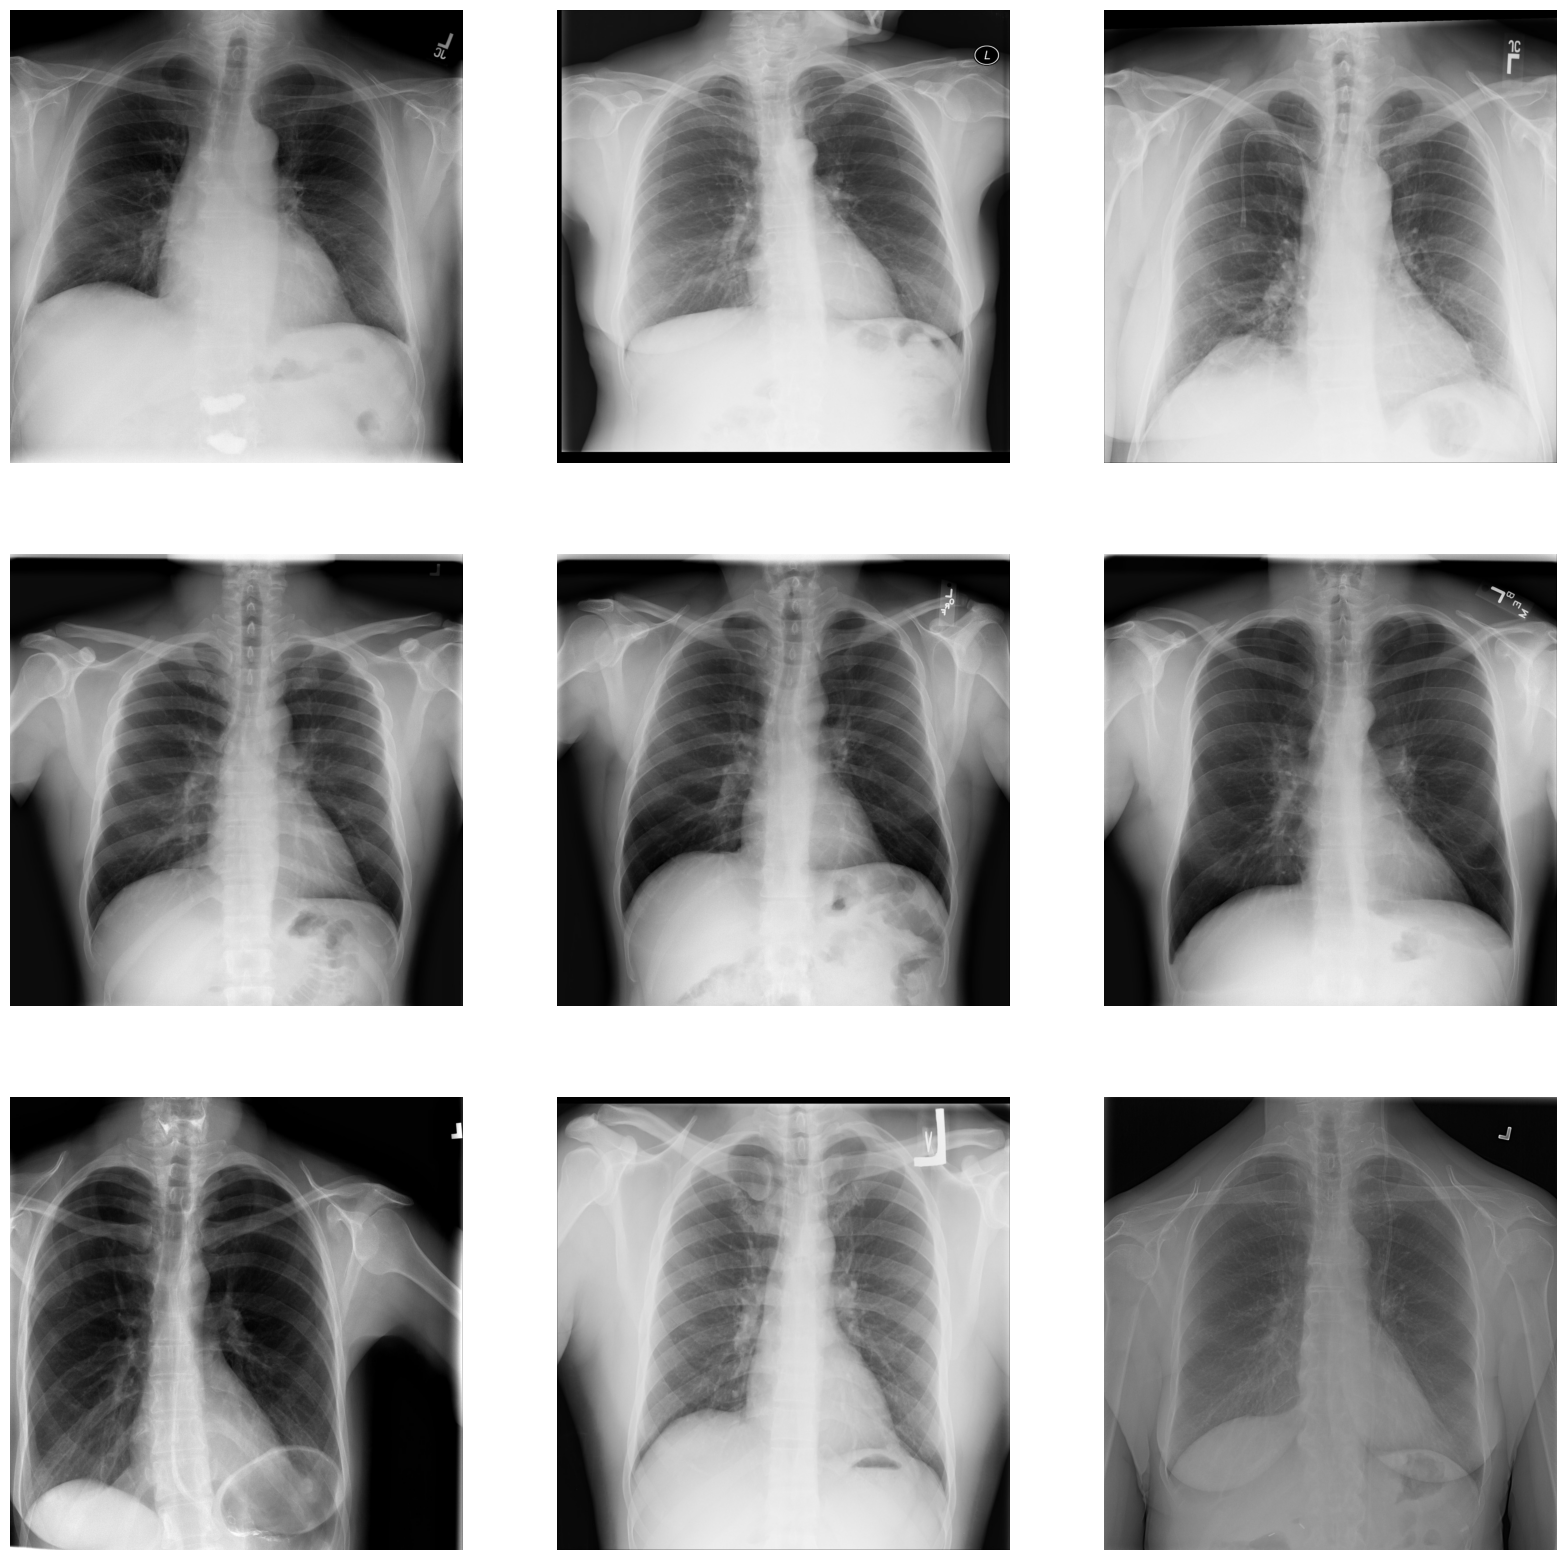

In [40]:
plt.style.use('default')
fig=plt.figure(figsize=(20, 20))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    draw(parsed[normal['patientId'].loc[i]])

In [ ]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [ ]:
# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 5000
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 21684
n valid samples 5000


Total train images: 26684
Images with pneumonia: 6012


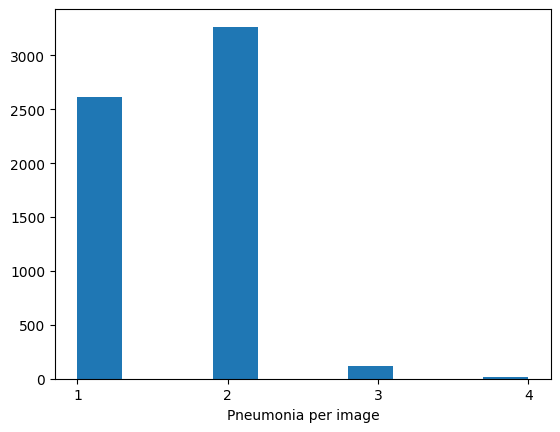

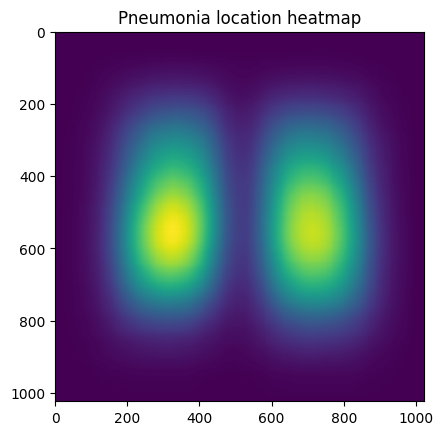

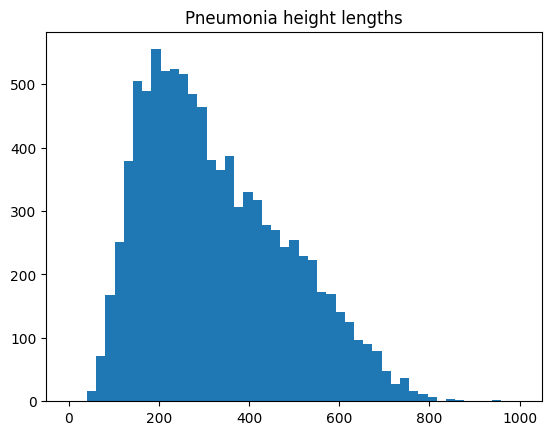

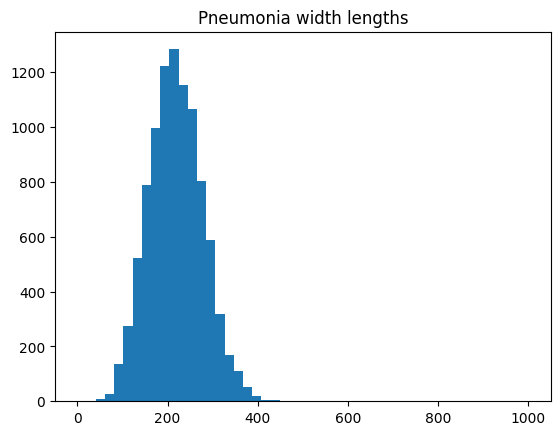

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [48]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))


**Modelling**

We will be using basic CNN model for training and predicting. Custom methods are created for the same.

In [41]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

The code below loads the table and transforms it into a dictionary.

The dictionary uses the filename as key and a list of pneumonia locations in that filename as value.
If a filename is not present in the dictionary it means that it contains no pneumonia.

In [42]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [43]:
# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

The generator takes in some filenames, batch_size and other parameters.

The generator outputs a random batch of numpy images and numpy masks.

In [44]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
                # if image contains pneumonia
        is_pneumonia = int(0)
        if filename in pneumonia_locations:
            # loop through pneumonia
                        # loop through pneumonia
            is_pneumonia = int(1)
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        #if self.augment and random.random() > 0.5:
         #   img = np.fliplr(img)
          #  msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        is_pneumonia = np.array(is_pneumonia)

        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [45]:
BATCH_SIZE = 16
IMAGE_SIZE = 320

In [46]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (8,8), (4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [47]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 320, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 320, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 320, 320, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
#X = tf.convert_to_tensor(train_gen,dtype=tf.int32)
#Y = tf.convert_to_tensor(valid_gen,dtype=tf.int32)

history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=5, shuffle=True)

Epoch 1/5
1507/1507 [==============================] - 2348s 2s/step - loss: 0.4884 - accuracy: 0.9600 - mean_iou: 0.5746 - val_loss: 0.5973 - val_accuracy: 0.8727 - val_mean_iou: 0.1930
Epoch 2/5
1507/1507 [==============================] - 2367s 2s/step - loss: 0.4566 - accuracy: 0.9626 - mean_iou: 0.6210 - val_loss: 0.4473 - val_accuracy: 0.9614 - val_mean_iou: 0.5885
Epoch 3/5
1507/1507 [==============================] - 2436s 2s/step - loss: 0.4446 - accuracy: 0.9644 - mean_iou: 0.6405 - val_loss: 0.4427 - val_accuracy: 0.9572 - val_mean_iou: 0.6131
Epoch 4/5
1507/1507 [==============================] - 2463s 2s/step - loss: 0.4371 - accuracy: 0.9655 - mean_iou: 0.6479 - val_loss: 0.4443 - val_accuracy: 0.9739 - val_mean_iou: 0.7383
Epoch 5/5
1507/1507 [==============================] - 2450s 2s/step - loss: 0.4272 - accuracy: 0.9668 - mean_iou: 0.6585 - val_loss: 0.5380 - val_accuracy: 0.9727 - val_mean_iou: 0.7528


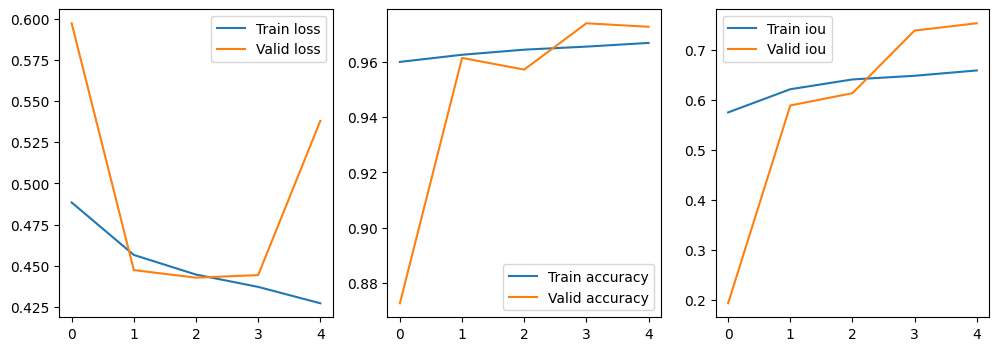

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
# load and shuffle filenames
folder = '/content/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=16, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
        
print("Done predicting...")
        
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000
Done predicting...


**TRY 2**

We have kept the image size and batch size same as earlier. Changed the number of layer for the next 3 tries in comparison to our base model(previous).

In [52]:
def create_network2(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9999)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [53]:
BATCH_SIZE = 16
IMAGE_SIZE = 320

In [54]:
# create network and compiler
model2 = create_network2(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model2.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model2.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 320, 320, 32) 288         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 320, 320, 32) 128         conv2d_45[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_44 (LeakyReLU)      (None, 320, 320, 32) 0           batch_normalization_44[0][0]     
_______________________________________________________________________________________

In [ ]:
history = model2.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=3, shuffle=True)

Epoch 1/3
1507/1507 [==============================] - 2261s 2s/step - loss: 0.4899 - accuracy: 0.9593 - mean_iou: 0.5900 - val_loss: 0.8302 - val_accuracy: 0.8405 - val_mean_iou: 0.0717
Epoch 2/3
1507/1507 [==============================] - 2295s 2s/step - loss: 0.4594 - accuracy: 0.9642 - mean_iou: 0.6362 - val_loss: 0.4995 - val_accuracy: 0.9451 - val_mean_iou: 0.1994
Epoch 3/3
1507/1507 [==============================] - 2277s 2s/step - loss: 0.4478 - accuracy: 0.9655 - mean_iou: 0.6543 - val_loss: 0.5116 - val_accuracy: 0.9391 - val_mean_iou: 0.3517


In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

**TRY 3**

Image size = 320 (Same) and batch size = 32 (Changed) 

In [59]:
def create_network3(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9999)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [63]:
BATCH_SIZE = 32
IMAGE_SIZE = 320

In [64]:
# create network and compiler
model3 = create_network3(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model3.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model3.summary())

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 320, 320, 32) 288         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_107 (BatchN (None, 320, 320, 32) 128         conv2d_111[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_107 (LeakyReLU)     (None, 320, 320, 32) 0           batch_normalization_107[0][0]    
______________________________________________________________________________________

In [65]:
history = model3.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=2, shuffle=True)

Epoch 1/2
753/753 [==============================] - 2522s 3s/step - loss: 0.4903 - accuracy: 0.9589 - mean_iou: 0.5849 - val_loss: 2.3293 - val_accuracy: 0.1696 - val_mean_iou: 0.0305
Epoch 2/2
753/753 [==============================] - 2479s 3s/step - loss: 0.4431 - accuracy: 0.9650 - mean_iou: 0.6528 - val_loss: 1.2182 - val_accuracy: 0.5124 - val_mean_iou: 0.0410


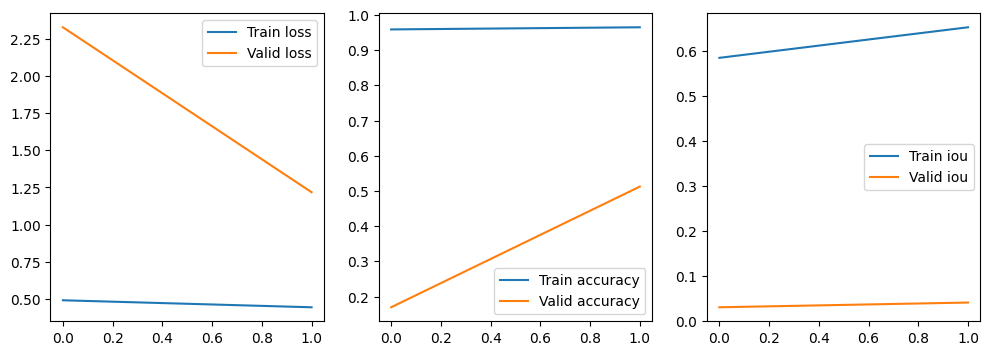

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

**TRY 4**

Changing Image Size and Batch Size to 48 and 256 respectively. Also depth is changed to 3 from 4

In [74]:
def create_network4(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9999)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [79]:
BATCH_SIZE = 48
IMAGE_SIZE = 256

In [80]:
# create network and compiler
model4 = create_network4(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=3)
model4.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model4.summary())

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 256, 256, 32) 288         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_212 (BatchN (None, 256, 256, 32) 128         conv2d_221[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_212 (LeakyReLU)     (None, 256, 256, 32) 0           batch_normalization_212[0][0]    
______________________________________________________________________________________

In [83]:
history = model4.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=2, shuffle=True)

Epoch 1/2
502/502 [==============================] - 2582s 5s/step - loss: 0.4845 - accuracy: 0.9589 - mean_iou: 0.5421 - val_loss: 2.3024 - val_accuracy: 0.5925 - val_mean_iou: 0.0443
Epoch 2/2
502/502 [==============================] - 2473s 5s/step - loss: 0.4511 - accuracy: 0.9637 - mean_iou: 0.5985 - val_loss: 0.5596 - val_accuracy: 0.9240 - val_mean_iou: 0.1296


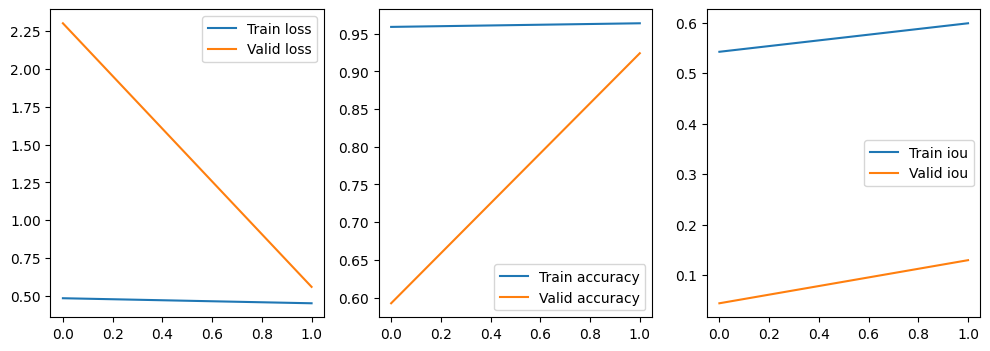

In [84]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

We complete our evaluation of RESNET modelling with four different attempts to hypertune.

The first base model remains to be the best model as per validation accuracy.

**UNET MODEL**


We have chosen UNET as our next model expecting better performances.


In [67]:
#!pip install pydicom

import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

import keras
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,UpSampling2D,Concatenate, SpatialDropout2D
from keras.callbacks import LearningRateScheduler

In [68]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/content/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [69]:
# load and shuffle filenames
folder = '/content/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 5000
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 21684
n valid samples 5000


Total train images: 26684
Images with pneumonia: 6012


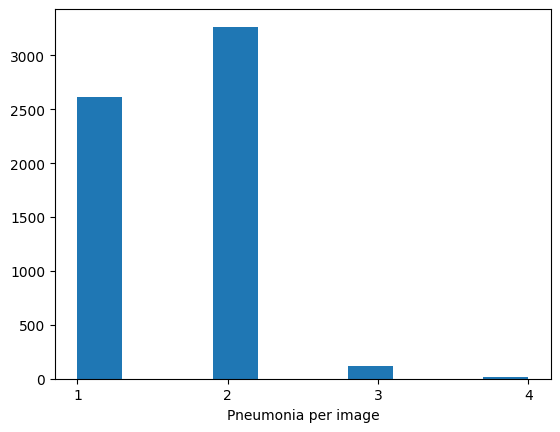

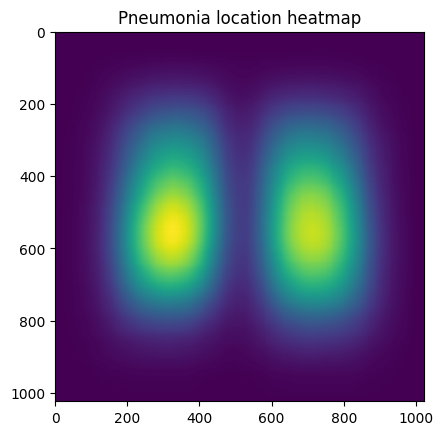

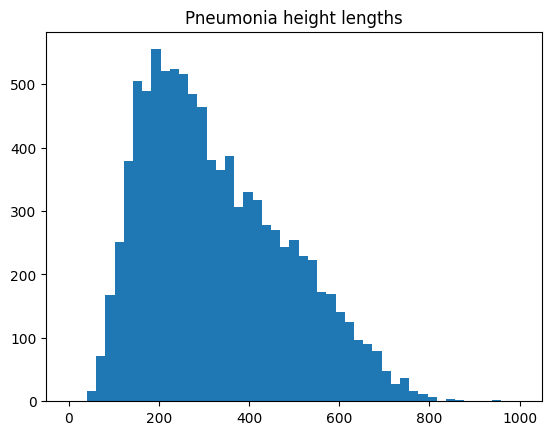

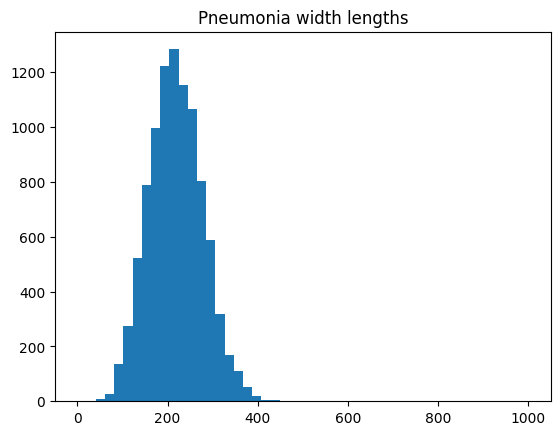

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [70]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))


In [71]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
                # if image contains pneumonia
        is_pneumonia = int(0)
        if filename in pneumonia_locations:
            # loop through pneumonia
                        # loop through pneumonia
            is_pneumonia = int(1)
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        #if self.augment and random.random() > 0.5:
         #   img = np.fliplr(img)
          #  msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        is_pneumonia = np.array(is_pneumonia)

        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [72]:
def conv_block(m, dim, acti, bn, res, do=0.5):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do=do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=True, maxpool=True, upconv=True, residual=True):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [73]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
#model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model = model = UNet((256,256,1),start_ch=32,depth=4,batchnorm=True)
model.summary()
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 256, 256, 32) 128         conv2d_115[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_36 (SpatialDr (None, 256, 256, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [77]:
BATCH_SIZE=16
IMAGE_SIZE=256

In [78]:
# create train and validation generators
folder = '/content/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)


In [79]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=5, shuffle=True)

Epoch 1/5
1355/1355 [==============================] - 2829s 2s/step - loss: 0.5185 - accuracy: 0.9572 - mean_iou: 0.4675 - val_loss: 0.5038 - val_accuracy: 0.9658 - val_mean_iou: 0.5447
Epoch 2/5
1355/1355 [==============================] - 2752s 2s/step - loss: 0.4855 - accuracy: 0.9585 - mean_iou: 0.4942 - val_loss: 0.4716 - val_accuracy: 0.9470 - val_mean_iou: 0.4599
Epoch 3/5
1355/1355 [==============================] - 2730s 2s/step - loss: 0.4631 - accuracy: 0.9618 - mean_iou: 0.5804 - val_loss: 0.4453 - val_accuracy: 0.9659 - val_mean_iou: 0.6457
Epoch 4/5
1355/1355 [==============================] - 2604s 2s/step - loss: 0.4524 - accuracy: 0.9635 - mean_iou: 0.6082 - val_loss: 0.5062 - val_accuracy: 0.9715 - val_mean_iou: 0.7245
Epoch 5/5
1355/1355 [==============================] - 2648s 2s/step - loss: 0.4459 - accuracy: 0.9640 - mean_iou: 0.6280 - val_loss: 0.4450 - val_accuracy: 0.9543 - val_mean_iou: 0.5764


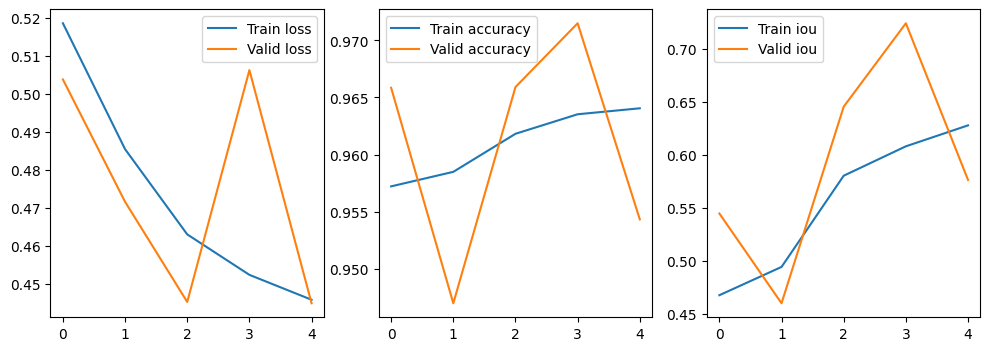

In [80]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

Validation accuracy has decreased from 3rd epcoh

**TRY 2**

For try 2: we change the image size to 320 from 256 keeping the batch size same as before.

In [85]:
BATCH_SIZE=16
IMAGE_SIZE=320

In [86]:
model = model = UNet((320,320,1),start_ch=32,depth=4,batchnorm=True)
model.summary()
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 320, 320, 32) 320         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_131 (BatchN (None, 320, 320, 32) 128         conv2d_161[0][0]                 
__________________________________________________________________________________________________
spatial_dropout2d_54 (SpatialDr (None, 320, 320, 32) 0           batch_normalization_131[0][0]    
_______________________________________________________________________________________

In [87]:
# create train and validation generators
folder = '/content/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)


In [88]:
history2 = model.fit(train_gen, validation_data=valid_gen, epochs=2, shuffle=True)

Epoch 1/2
1355/1355 [==============================] - 2775s 2s/step - loss: 0.5237 - accuracy: 0.9598 - mean_iou: 0.4756 - val_loss: 0.5053 - val_accuracy: 0.9441 - val_mean_iou: 0.2851
Epoch 2/2
1355/1355 [==============================] - 2728s 2s/step - loss: 0.5007 - accuracy: 0.9579 - mean_iou: 0.4492 - val_loss: 0.5675 - val_accuracy: 0.9713 - val_mean_iou: 0.7691


In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history2.epoch, history2.history["loss"], label="Train loss")
plt.plot(history2.epoch, history2.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history2.epoch, history2.history["accuracy"], label="Train accuracy")
plt.plot(history2.epoch, history2.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history2.epoch, history2.history["mean_iou"], label="Train iou")
plt.plot(history2.epoch, history2.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

We were not able to improve from our initial base model of RESNET. Our basis of best model is on validation accuracy which is found to be at 97.36% (RESNET base model)